In [18]:
directory_path = 'data/task_7'

import os 
entries = os.listdir(directory_path)
files = sorted([entry for entry in entries if os.path.isfile(os.path.join(directory_path, entry))])

import pickle
list_of_dict = []
for file_name in files: 
    file_path = os.path.join(directory_path,file_name)
    with open(file_path, 'rb') as file: 
        dict = pickle.load(file)
        list_of_dict.append(dict)
        
print(f"Number of files in \"{directory_path}\": \t{len(files)}")
print(f"Number of files in imported list: \t{len(list_of_dict)}")

Number of files in "data/task_7": 	47455
Number of files in imported list: 	47455


[0, 82.31310835759855, 95.09324404707772, 59.47143570147035, 54.44471209318987, 42.703320382027606, 90.9854101074655, 36.56325744071861, 0]
[0, 70.60097540877298, 45.79684649342082, 35.51945276851168, 25.759141374824615, 57.36565710316881, 53.23116900317908, 74.20117341198298, 0]
Processing Time is 15392.0


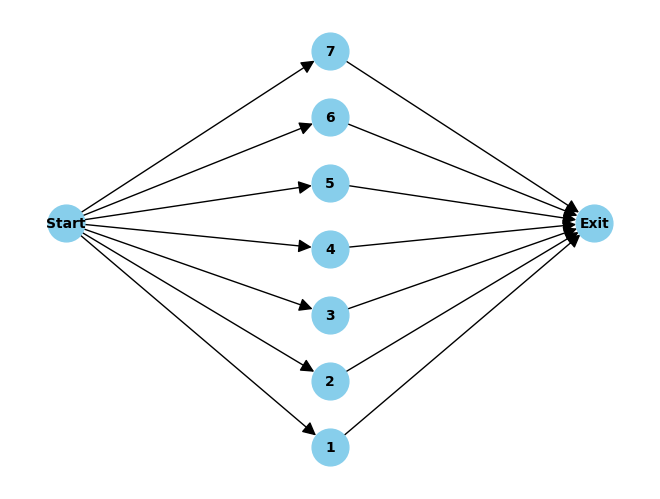

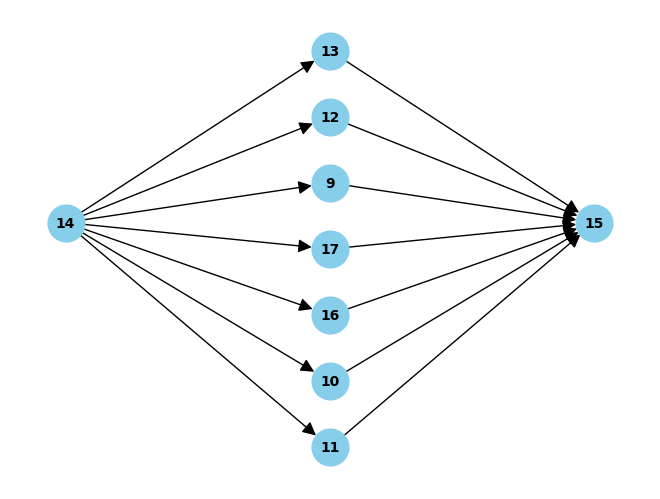


Num of PE's = 9


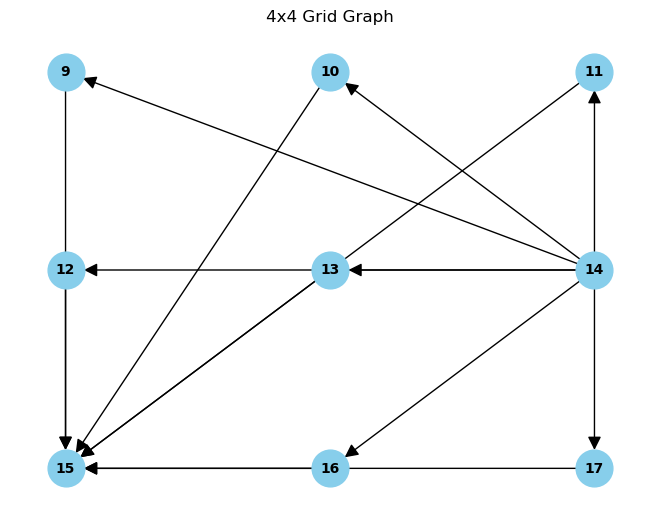

In [19]:
import sys
sys.path.append('../gcn')
from gcn.utils import *

task = list_of_dict[1000]
task_graph = task['task_graph']

map_graph = task['map_graph']
task_demands = [demands[0] for demands in task['demand']]
task_demands.insert(0,0)
task_demands.append(0)
task_duration = task['duration']
task_duration.insert(0,0)
task_duration.append(0)
task_processing_time = task['processing_time']

print(task_demands)
print(task_duration)
print(f"Processing Time is {task['processing_time']}")

visGraph(task_graph, pos=task['task_graph_pos'])
visGraph(map_graph, pos=task['map_graph_pos'])
visGraphGrid(map_graph.edges, net_3x3)

In [20]:
import torch
from torch_geometric.data import Data

edge_list = list(map_graph.edges) 
node_list = list(map_graph.nodes)
node_mapping = {old_index: new_index for new_index, old_index in enumerate(node_list)}

edge_index = torch.tensor([(node_mapping[edge[0]], node_mapping[edge[1]]) for edge in edge_list]).t().contiguous()

In [21]:
# pe = torch.tensor(node_list).view(-1,1).float()
demand = torch.tensor(task_demands).view(-1,1).float()
duration = torch.tensor(task_duration).view(-1,1).float()

x = torch.cat([ demand, duration], dim=1)
print(f"Node Level Feature \n{x}\n")

distance_list = []
for edge in edge_list:
    src_node = edge[0]
    dest_node = edge[1]

    src_node_loc = net_3x3[src_node]
    dest_node_loc = net_3x3[dest_node]

    distance = manhattan_distance(src_node_loc, dest_node_loc)
    distance_list.append(distance)

edge_attr = torch.tensor(distance_list).view(-1,1).float()
print(f"Edge Level feature \n{distance}\n")

target_label = torch.tensor([task_processing_time]).float()

data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=target_label)
print(data)
print(data.validate())
print(data.is_directed())
print(f"Input Feature Size is {data.x.shape}")

Node Level Feature 
tensor([[ 0.0000,  0.0000],
        [82.3131, 70.6010],
        [95.0932, 45.7968],
        [59.4714, 35.5195],
        [54.4447, 25.7591],
        [42.7033, 57.3657],
        [90.9854, 53.2312],
        [36.5633, 74.2012],
        [ 0.0000,  0.0000]])

Edge Level feature 
2

Data(x=[9, 2], edge_index=[2, 14], edge_attr=[14, 1], y=[1])
True
True


In [27]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

torch.manual_seed(420)

class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, 1)  # Fully connected layer for scalar output

    def forward(self, x, edge_index, edge_attr):
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = F.relu(self.conv2(x, edge_index, edge_attr))
        x = F.relu(self.fc(x.mean(dim=0)))  # Average pooling and apply fully connected layer
        return x


# Define the dimensions
input_dim = 2  # Node-level feature dimension
hidden_dim = 64
output_dim = 1  # You may adjust this based on your specific task

model = GCN(input_dim, hidden_dim)
output = model(x, edge_index, edge_attr)
print(f"Output is {output}")
print(f"target_label is {target_label}")

criterion = nn.MSELoss()
loss = criterion(output, target_label)
print(f"Loss(MSE) is {loss}")

print(f"\nModel is\n{model}")

Output is tensor([1.1045], grad_fn=<ReluBackward0>)
target_label is tensor([15392.])
Loss(MSE) is 236879664.0

Model is
GCN(
  (conv1): GCNConv(2, 64)
  (conv2): GCNConv(64, 64)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)
